# NBA Data Exploration
## Bryce Mann

#### Pulling season advanced stats for every team.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

from utils import decorate
from thinkstats2 import Pmf, Cdf

import thinkstats2
import thinkplot
from datetime import datetime
import time

In [2]:
from nba_api.stats.endpoints import leaguedashteamstats as ts
from nba_api.stats.library.parameters import MeasureTypeDetailed

#advanced stats
adv = MeasureTypeDetailed.advanced

In [3]:
def make_season_list(year1, year2):
    #format nba_api wants seasons in
    seasons = []
    for n in range(year1, year2):
        season = str(n) + '-' + str(n+1)[2:]
        seasons.append(season)
    return seasons

In [4]:
def pull_dfs(clss, y1, y2, **kwargs):
    #store advanced team stats locally
    seasons = make_season_list(y1, y2)
    for season in seasons:
        data = clss(season=season, **kwargs)
        temp_df = data.get_data_frames()[0]
        temp_df['Season'] = season
        pd.to_pickle(temp_df, 'teams_adv/' + str(season) + '.pkl')

# pull_dfs(ts.LeagueDashTeamStats, 1996, 2019,
#          measure_type_detailed_defense=adv)

In [5]:
test = pd.read_pickle('teams_adv/2018-19.pkl')
test.columns

Index(['TEAM_ID', 'TEAM_NAME', 'GP', 'W', 'L', 'W_PCT', 'MIN', 'E_OFF_RATING',
       'OFF_RATING', 'E_DEF_RATING', 'DEF_RATING', 'E_NET_RATING',
       'NET_RATING', 'AST_PCT', 'AST_TO', 'AST_RATIO', 'OREB_PCT', 'DREB_PCT',
       'REB_PCT', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'E_PACE', 'PACE', 'PIE',
       'GP_RANK', 'W_RANK', 'L_RANK', 'W_PCT_RANK', 'MIN_RANK',
       'OFF_RATING_RANK', 'DEF_RATING_RANK', 'NET_RATING_RANK', 'AST_PCT_RANK',
       'AST_TO_RANK', 'AST_RATIO_RANK', 'OREB_PCT_RANK', 'DREB_PCT_RANK',
       'REB_PCT_RANK', 'TM_TOV_PCT_RANK', 'EFG_PCT_RANK', 'TS_PCT_RANK',
       'PACE_RANK', 'PIE_RANK', 'CFID', 'CFPARAMS', 'Season'],
      dtype='object')

### Is offense getting more important?
**Many basketball analysts today say that offense is becoming more important to team success and that the NBA will continue to trend that way. Is it true?**

To try an answer this question I look at advanced team stats from the first year they were collected (1996) to this past season. The two in particular I look at are Offensive and Defensive efficency, or the amount of points a team scores and gives up, respectively, per 100 possessions; this is probably the most baseline measure of a team these days, in terms of advanced stats. To see what I was working with I first normalized the efficiencies of each season, then plotted each teams numbers (offensive on the x-axis, defensive on the inverted y-axis; the teams good on both sides of the ball are on the top right), with the dot size indicating where they ended in the league standings that year. The larger the dot, the better the team.

/home/bryce/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/bryce/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/bryce/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly clo

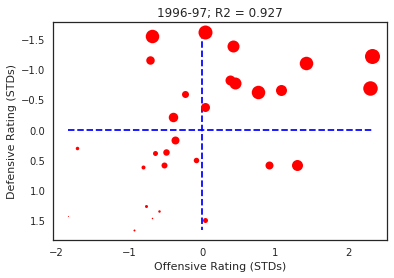

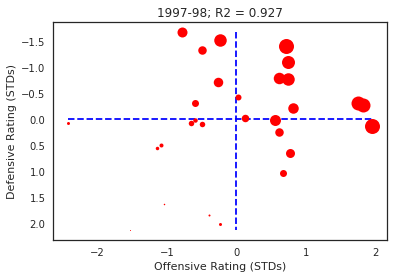

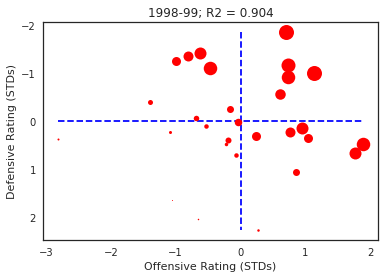

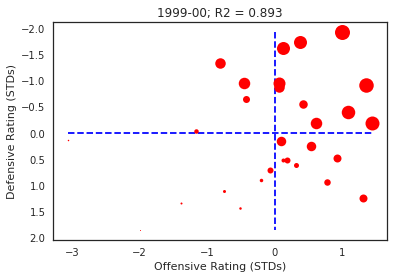

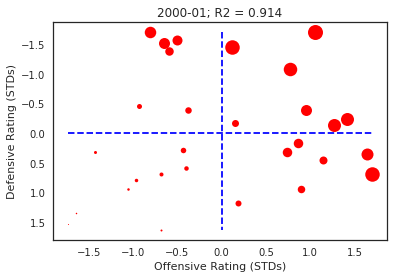

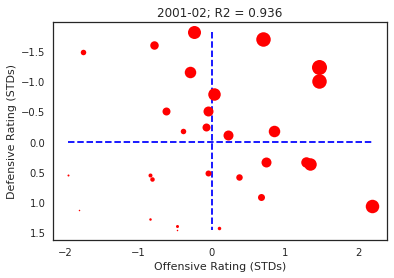

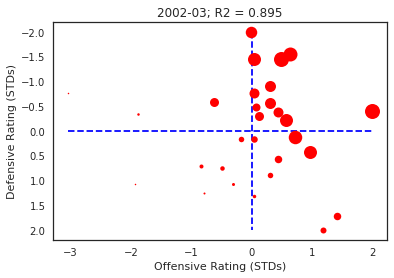

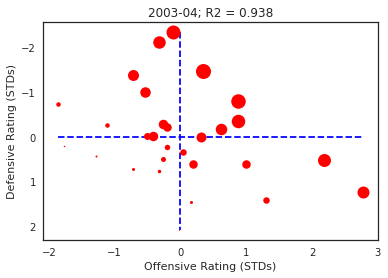

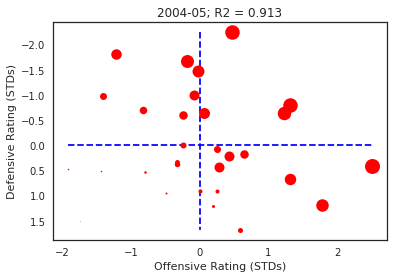

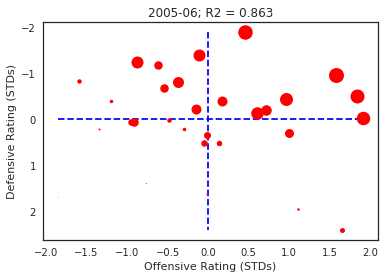

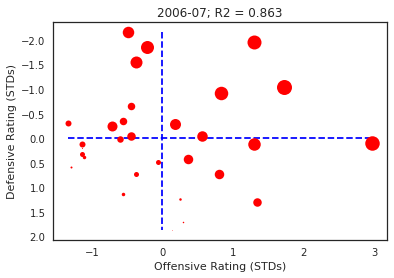

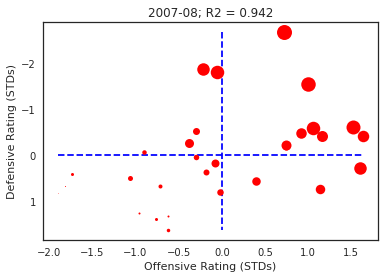

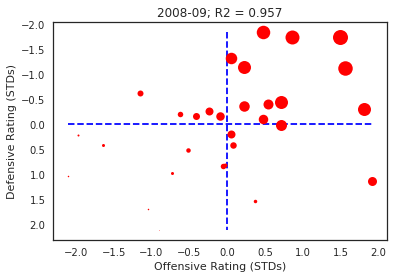

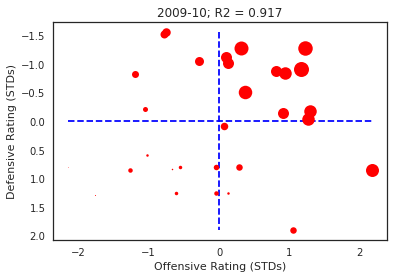

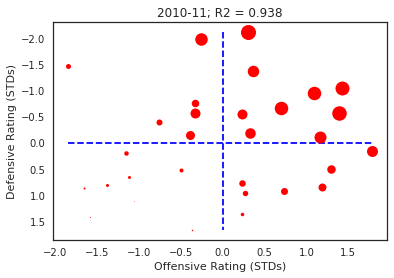

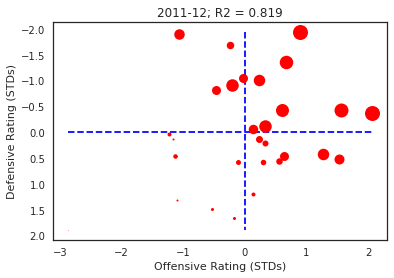

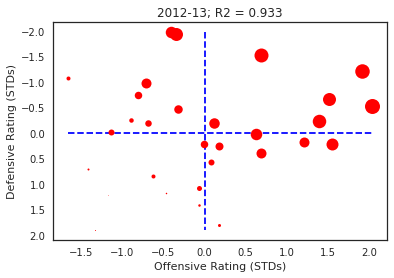

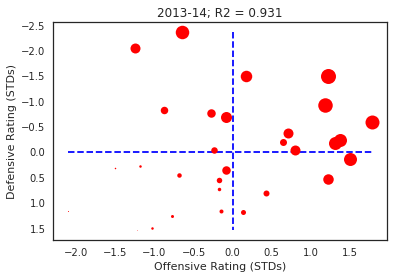

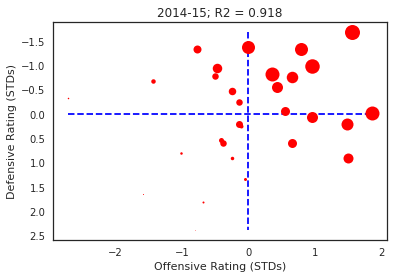

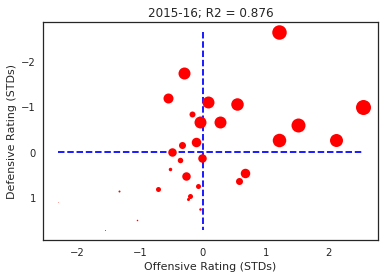

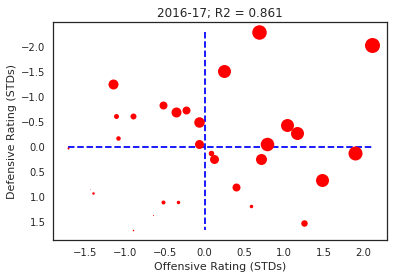

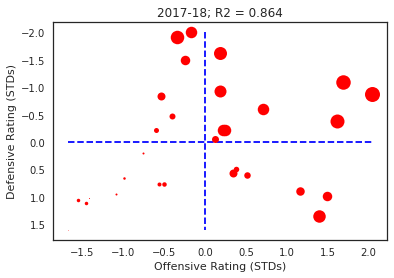

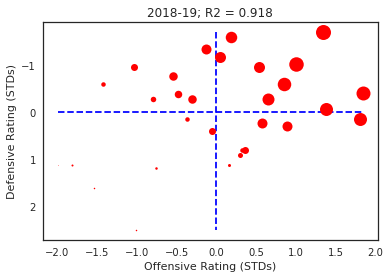

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize
from sklearn.feature_selection import f_regression

seasons = make_season_list(1996, 2019)
d = dict()

for season in seasons:
    
    #read grab each season dataframe
    df = pd.read_pickle('teams_adv/' + season + '.pkl')
    
    #normalize off and def efficiency
    x = df['OFF_RATING']
    xnorm = (x - np.mean(x))/np.std(x)
    y = df['DEF_RATING']
    ynorm = (y - np.mean(y))/np.std(y)
    avgx = np.mean(x)
    avgy = np.mean(y)
    
    #initialize normalized linear regression class
    linreg = LinearRegression(normalize=True)
    X = df[['OFF_RATING', 'DEF_RATING']]
    Y = df['W_RANK']
    #fit to the data, compute r2, store coefficients for the season
    linreg.fit(X,Y)
    r2 = linreg.score(X, Y)
    d[season] = linreg.coef_
    
    #plotting each season
    plt.figure()
    plt.title(season + '; R2 = ' + str(np.around(r2,3)))
    plt.gca().invert_yaxis()
    plt.xlabel('Offensive Rating (STDs)')
    plt.ylabel('Defensive Rating (STDs)')
    plt.plot([0, 0], [min(ynorm), max(ynorm)], 'b--')
    plt.plot([min(xnorm), max(xnorm)], [0, 0], 'b--')
    #size of the marker determined by how successful the team was
    for i, val in enumerate(xnorm):
        size = (31 - df['W_RANK'].values[i])
        plt.plot(xnorm[i],ynorm[i],'r.', markersize=size)

**Results**

Once I plotted efficiencies and standing rank I wanted to see if the relative importance of either side of the ball has been increasing or decreasing as the years have gone by. To look at this I plotted the ratio of the coefficients corresponding the each efficiency against the year that ratio was computed for. As the ratio goes farther from 0, the more dependent on offensive production teams are to win. Looking at the straight scatter plot doesn't jump out, so I run regression on it below.

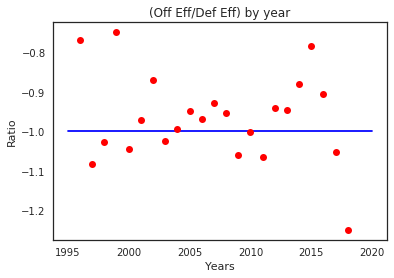

In [7]:
plt.figure()
plt.plot([1995, 2020], [-1, -1], 'b-')
plt.title('(Off Eff/Def Eff) by year')
plt.xlabel('Years')
plt.ylabel('Ratio')

ratios = []

#for each season plot the ratio as well as identity line at -1
for season in seasons:
    ratio = d[season][0]/d[season][1]
    ratios.append(ratio)
    plt.plot(int(season[0:4]),ratio, 'ro')

**Correlation Matrix**

At first glance it doesn't seem like the ratio can be very well explained by the season number or season squared.

In [8]:
df = pd.DataFrame(
    {'season': range(1996,2019),
     'season2': [x**2 for x in range(1996,2019)],
     'ratio': ratios,
     })
df.corr()

,season,season2,ratio
season,1.000000,0.999999,-0.217065
season2,0.999999,1.000000,-0.217134
ratio,-0.217065,-0.217134,1.000000


In [9]:
from sklearn.feature_selection import f_regression

#first order fit of ratios vs season
x = df['season'].values.reshape(-1,1)
y = df['ratio'].values.reshape(-1,1)
linreg = LinearRegression()
linreg.fit(x,y)

#r2 and pval of model
r1 = linreg.score(x,y)
F, p1 = f_regression(x,y)

#coef p, not pvalue
p = [linreg.coef_[0][0], linreg.intercept_]

#first order best fit
x1 = np.linspace(1996,2018,100)
y1 = np.polyval(p, x1)
p1

/home/bryce/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.31979443])

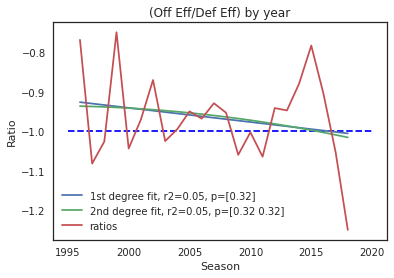

In [10]:
#second order fit of ratios vs season
linreg = LinearRegression()
x2 = df[['season', 'season2']].values
y = df['ratio'].values.reshape(-1,1)
linreg.fit(x2,y)

#r2 and pvals of model
r2 = linreg.score(x2,y)
F, p2 = f_regression(x2,y)

#coefp, not value
p = [linreg.coef_[0][1], linreg.coef_[0][0], linreg.intercept_]

#second order best fit
x2 = np.linspace(1996,2018,100)
y2 = np.polyval(p, x2)

#plotting
plt.figure()
plt.plot([1995, 2020], [-1, -1], 'b--')
plt.title('(Off Eff/Def Eff) by year')
plt.xlabel('Season')
plt.ylabel('Ratio')

plt.plot(x1, y1, label='1st degree fit, r2=' + str(np.around(r1,2)) + 
         ', p=' + str(np.around(p1,2)))
plt.plot(x2, y2, label='2nd degree fit, r2=' + str(np.around(r2,2)) + 
         ', p=' + str(np.around(p2,2)))
plt.plot(df['season'].values, ratios, label='ratios')

plt.legend()
plt.show()

## Conclusion
There is a definite negative trend as the years have gone by, but there is a lot of noise in the data as well, so it looks most likely like it is due to randomness. The low pvalues back that up.

# Who is (in)consistent?
**Here I set out to see who are the most consistent and inconsistent performers in the NBA**

The next 2 cells pull data. The easiest way to store all game box scores that I found is to load leaguegamefinder with a team id and set player_or_team_abbreviation = PlayerOrTeamAbbreviation.player

You can then go team by team, sort by player, and then have all of the games a certain player played in the season

In [11]:
from nba_api.stats.static import teams

nba_teams = teams.get_teams()
tid_list = []
abv_list = []

#list of team ids
for i in range(len(nba_teams)):
    tup1 = nba_teams[i]['id']
    tup2 = nba_teams[i]['abbreviation']
    tid_list.append(tup1)
    abv_list.append(tup2)

In [12]:
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.library.parameters import PlayerOrTeamAbbreviation
from nba_api.stats.library.parameters import Season
import requests_cache #sometimes needed to help with timeout errors
from datetime import datetime
from dateutil.parser import parse

#requests_cache.install_cache('demo_cache')

#return a df that starts on the first game the player had of the
#2018-19 regular season
def date_from(df, y=2018, m=10, d=16):
    idx = []
    while len(idx)==0:
        date = str(y) + '-' + str(m) + '-' + str(d)
        idx = df.loc[df['GAME_DATE']==date].index
        d += 1
        if d==32:
            d = 1
            m += 1
    return df.truncate(after=max(idx))

# for tid in tid_list:
#     gamefinder = leaguegamefinder.LeagueGameFinder(
#                  player_or_team_abbreviation=PlayerOrTeamAbbreviation.player,
#                  team_id_nullable=tid)

#     games = gamefinder.get_data_frames()[0]
#     games = games[games['SEASON_ID']=='22018']
#     games = date_from(games)
    
    
#     pd.to_pickle(games, 'games/' + str(tid) + '.pkl')

In [13]:
test = pd.read_pickle('games/' + str(tid_list[6]) + '.pkl')
test.columns

Index(['SEASON_ID', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION',
       'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'PTS',
       'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PLUS_MINUS'],
      dtype='object')

**Functions used to compute everything I need for consistency**

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#return the 20 game slice around current game index
def get_chunk(df, i, column='PTS'):
    
    length = len(df)
    
    #if before game 10
    if i < 11:
        idx1 = 0
        idx2 = i+10
    #if after the 10th last game
    elif i > length-10:
        idx1 = i-10
        idx2 = length
    #middle
    else:
        idx1 = i - 10
        idx2 = i + 10
    
    return df.iloc[idx1:idx2]

#given slice of 20 games, compute mse at that
def calc_mse(chunk, column=''):
    
    x = np.array(chunk.index).reshape(-1,1)
    y = np.array(chunk[column]).reshape(-1,1)
    
    linreg = LinearRegression()
    linreg.fit(x,y)
    y_pred = linreg.predict(x)
    
    mse = mean_squared_error(y, y_pred)
    
    return mse

#given a df with a players mse values (consistency), their player id
#given a df with the minimum mses (d_min)
#calculate whether consistency should be added to d_min 
def calc_min(d_min, consistency, pid):

    #if d_min is empty, start it
    if len(d_min.columns) < 1:
        d_min[pid] = consistency[pid].values
        return d_min
    
    #set the high mse, pid values to be the new player
    high_mse = np.mean(consistency[pid].dropna())
    high_pid = pid
    
    #each column name of d_min is a pid
    #each row is an mse value computed from calc_mse
    for col in d_min:
        temp_mse = np.mean(d_min[col].dropna())
        #if old high mse is less than a d_min mse
        #replace high mse and pid
        if high_mse < temp_mse:
            high_mse = temp_mse
            high_pid = col
    
    #if high pid changed, add the new pid to d_min
    #pop the high mse and pid off
    if high_pid != pid:
        d_min[pid] = consistency[pid].values
        idc = d_min.pop(high_pid)
        return d_min
    #if nothing changed return the same dataframe
    else:
        return d_min

#same as above, looking for high instead of low values
def calc_max(d_max, consistency, pid):
    
    if len(d_max.columns) < 1:
        d_max[pid] = consistency[pid].values
        return d_max
    
    low_mse = np.mean(consistency[pid].dropna())
    low_pid = pid
    
    for col in d_max:
        temp_mse = np.mean(d_max[col].dropna())
        if low_mse > temp_mse:
            low_mse = temp_mse
            low_pid = col
        
    if low_pid != pid:
        d_max[pid] = consistency[pid].values
        idc = d_max.pop(low_pid)
        return d_max
    else:
        return d_max    

#given a player and all of their games, return d_min and d_max
#after that player has been evaluated
def loop_games(df, d_min, d_max, pid, column='PTS'):
    
    #reset index to 0
    df2 = df.reset_index()
    
    #if the player played less than half of the games, skip
    if len(df2) > 41:
        
        nan_list = 83*[np.nan]
        consistency = pd.DataFrame(data=nan_list, columns=[pid])
        
        #for each row, get 20 game slice, calculate mse,
        #and add that mse to the consistency dataframe
        for idx, row in df2.iterrows():
                       
            chunk = get_chunk(df2, idx, column=column)
            try:
                mse = calc_mse(chunk, column=column)
            except:
                return d_min, d_max
            consistency[pid].iloc[idx] = mse
        
        #see if pid is low or high enough to get into
        #either dmin or dmax
        new_dmin = calc_min(d_min, consistency, pid)
        new_dmax = calc_max(d_max, consistency, pid)
        
        return new_dmin, new_dmax
    return d_min, d_max
 
#given list of team ids, calculate most consistent and inconsistent
#nba players
#threshold is lower bound on counting stat per game avg
def loop_teams(tid_list, column='PTS', threshold=15):
        
    d_min = pd.DataFrame()
    d_max = pd.DataFrame()
    
    #for each team get df of box scores, sort df by player id
    for tid in tid_list:
        team_df = pd.read_pickle('games/' + str(tid) + '.pkl')
        grouped = team_df.groupby('PLAYER_ID')
        #for each player, see if their avg is above the threshold
        #and if it is compute efficiency
        for name, group in grouped:
            player_df = grouped.get_group(name)
    
            avg = np.mean(player_df[column].values)
                
            if avg >= threshold:
                d_min, d_max= loop_games(player_df, d_min, d_max,
                                         name, column=column)
            else:
                pass
    return d_min, d_max

**Methodology**
With the function I wrote above, I can enter a box score statistic and a lower bound threshold, where no one who averaged less than that value for a whole season can be considered. From there it goes through every game they played during the season; for each game it runs linear regression on the 20 games around it. From there it uses that model and the actual point totals to compute the mean squared error of each game. As of right now I then average the mean squared errors, and save the players with the 3 largest and smallest averages.

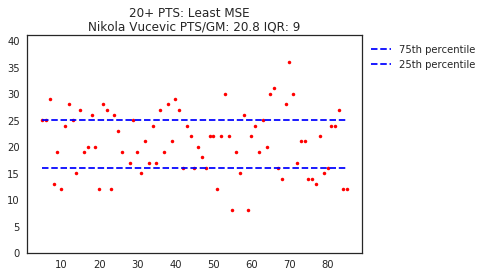

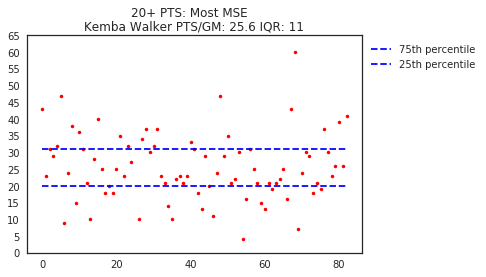

In [15]:
from nba_api.stats.static import players
from matplotlib.pyplot import subplots_adjust
from thinkstats2 import Cdf
from matplotlib.pyplot import yticks

columns = ['PTS']
thresholds = [20]

#for each column (only one atm)
for i in range(len(columns)):
    
    #calc dmin and dmax
    dmin, dmax = loop_teams(tid_list, column=columns[i],
                            threshold=thresholds[i])
    
    #starting min subplot
    fig1 = plt.figure()
    fig1.suptitle(str(thresholds[i]) + '+ ' + columns[i] +
                 ': Least MSE')
    plt.xlabel('Games')
    plt.ylabel('Total ' + columns[i])
    
    #inc
    n = 1
    
    #ylims
    high = 0
    low = 0
    
    #for each player in the dmin df
    for col in dmin:
        ax = plt.subplot("11"+str(n))
        n += 1
        
        #get raw game box scores from 2018-19 reg season
        gamefinder = leaguegamefinder.LeagueGameFinder(
        player_or_team_abbreviation=PlayerOrTeamAbbreviation.player,
        player_id_nullable=int(col))
        games = gamefinder.get_data_frames()[0]
        games = games[games['SEASON_ID']=='22018']
        games = date_from(games)
        
        #set ylims
        high = max(max(games[columns[i]].values), high)
        low = min(min(games[columns[i]].values), low)
        
        #calculate IQR of game stat values
        cdf = Cdf(games[columns[i]].values)
        [lqr, uqr] = cdf.Percentile(25), cdf.Percentile(75) 
        
        #plotting and labeling
        ax.plot(games.index, games[columns[i]].values, 'r.')
        
        ax.plot([min(games.index), max(games.index)], [uqr, uqr],
                'b--', label='75th percentile')
        ax.plot([min(games.index), max(games.index)], [lqr, lqr],
                'b--', label='25th percentile') 
        
        p = players.find_player_by_id(int(col))
        name = p['full_name']
        avg = np.mean(games[columns[i]].values)
        ax.set_title(name + ' ' + columns[i] + '/GM: ' + 
                     str(np.around(avg, 1)) + ' IQR: ' +
                    str(np.around(uqr-lqr, 3)))
        ax.legend(bbox_to_anchor=(1, 1))
    
    yticks(np.arange(0, 100, step=5))
    plt.ylim([low, high+5])
    plt.subplots_adjust(hspace=1)
    plt.show()

    #same as above for dmax subplots
    fig2 = plt.figure()
    fig2.suptitle(str(thresholds[i]) + '+ ' + columns[i] + ': Most MSE')
    plt.xlabel('Games')
    plt.ylabel('Total ' + columns[i])
    
    n = 1
    
    high = 0
    low = 0
    
    for col in dmax:
        ax = plt.subplot("11"+str(n))
        n += 1
        
        gamefinder = leaguegamefinder.LeagueGameFinder(
        player_or_team_abbreviation=PlayerOrTeamAbbreviation.player,
        player_id_nullable=int(col))
        games = gamefinder.get_data_frames()[0]
        games = games[games['SEASON_ID']=='22018']
        games = date_from(games)
        
        high = max(max(games[columns[i]].values), high)
        low = min(min(games[columns[i]].values), low)
        cdf = Cdf(games[columns[i]].values)
        [lqr, uqr] = cdf.Percentile(25), cdf.Percentile(75)

        ax.plot(games.index, games[columns[i]].values, 'r.')
        
        ax.plot([min(games.index), max(games.index)], [uqr, uqr],
                'b--', label='75th percentile')
        ax.plot([min(games.index), max(games.index)], [lqr, lqr],
                'b--', label='25th percentile')
        
        p = players.find_player_by_id(int(col))
        name = p['full_name']
        avg = np.mean(games[columns[i]].values)
        ax.set_title(name + ' ' + columns[i] + '/GM: ' + 
                     str(np.around(avg, 1)) + ' IQR: ' +
                     str(np.around(uqr-lqr, 3)))
        ax.legend(bbox_to_anchor=(1, 1))
      
    yticks(np.arange(0, 100, step=5))
    plt.ylim([low, high+5])
    plt.subplots_adjust(hspace=1)
    plt.show()

**Results**

I just got this working, I will take a few minutes today to mess around with columns and threshold values to see if anything really interesting comes up. Each plot has the box score values from every game the player played in this past season, along with the IQR of all of those values and their per game averages.

# Positions, are they useless?
**Using a KNeighbors model, I will try to see if position designations are becoming less meaningful as time goes on**

coming soon...